In [29]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(harmony))
suppressMessages(library(Nebulosa))

In [30]:
set.seed(42)
getwd()

[1] "/data/scATA/SingleCellOpenChromatin/local/VisiumHeartRevision/IntegrativeAnalysis/Lymphoid/code"

In [31]:
coembed <- readRDS("../data/coembed/coembed.Rds")
coembed

An object of class Seurat 
159644 features across 6132 samples within 3 assays 
Active assay: RNA (28933 features, 2000 variable features)
 2 other assays present: peaks, GeneActivity
 4 dimensional reductions calculated: pca, umap, harmony, umap_harmony

In [32]:
coembed@meta.data$`RNA_snn_res.0.1` <- NULL
coembed@meta.data$`RNA_snn_res.0.2` <- NULL
coembed@meta.data$`RNA_snn_res.0.4` <- NULL
coembed@meta.data$`RNA_snn_res.0.6` <- NULL
coembed@meta.data$`RNA_snn_res.0.8` <- NULL
coembed@meta.data$`RNA_snn_res.1` <- NULL

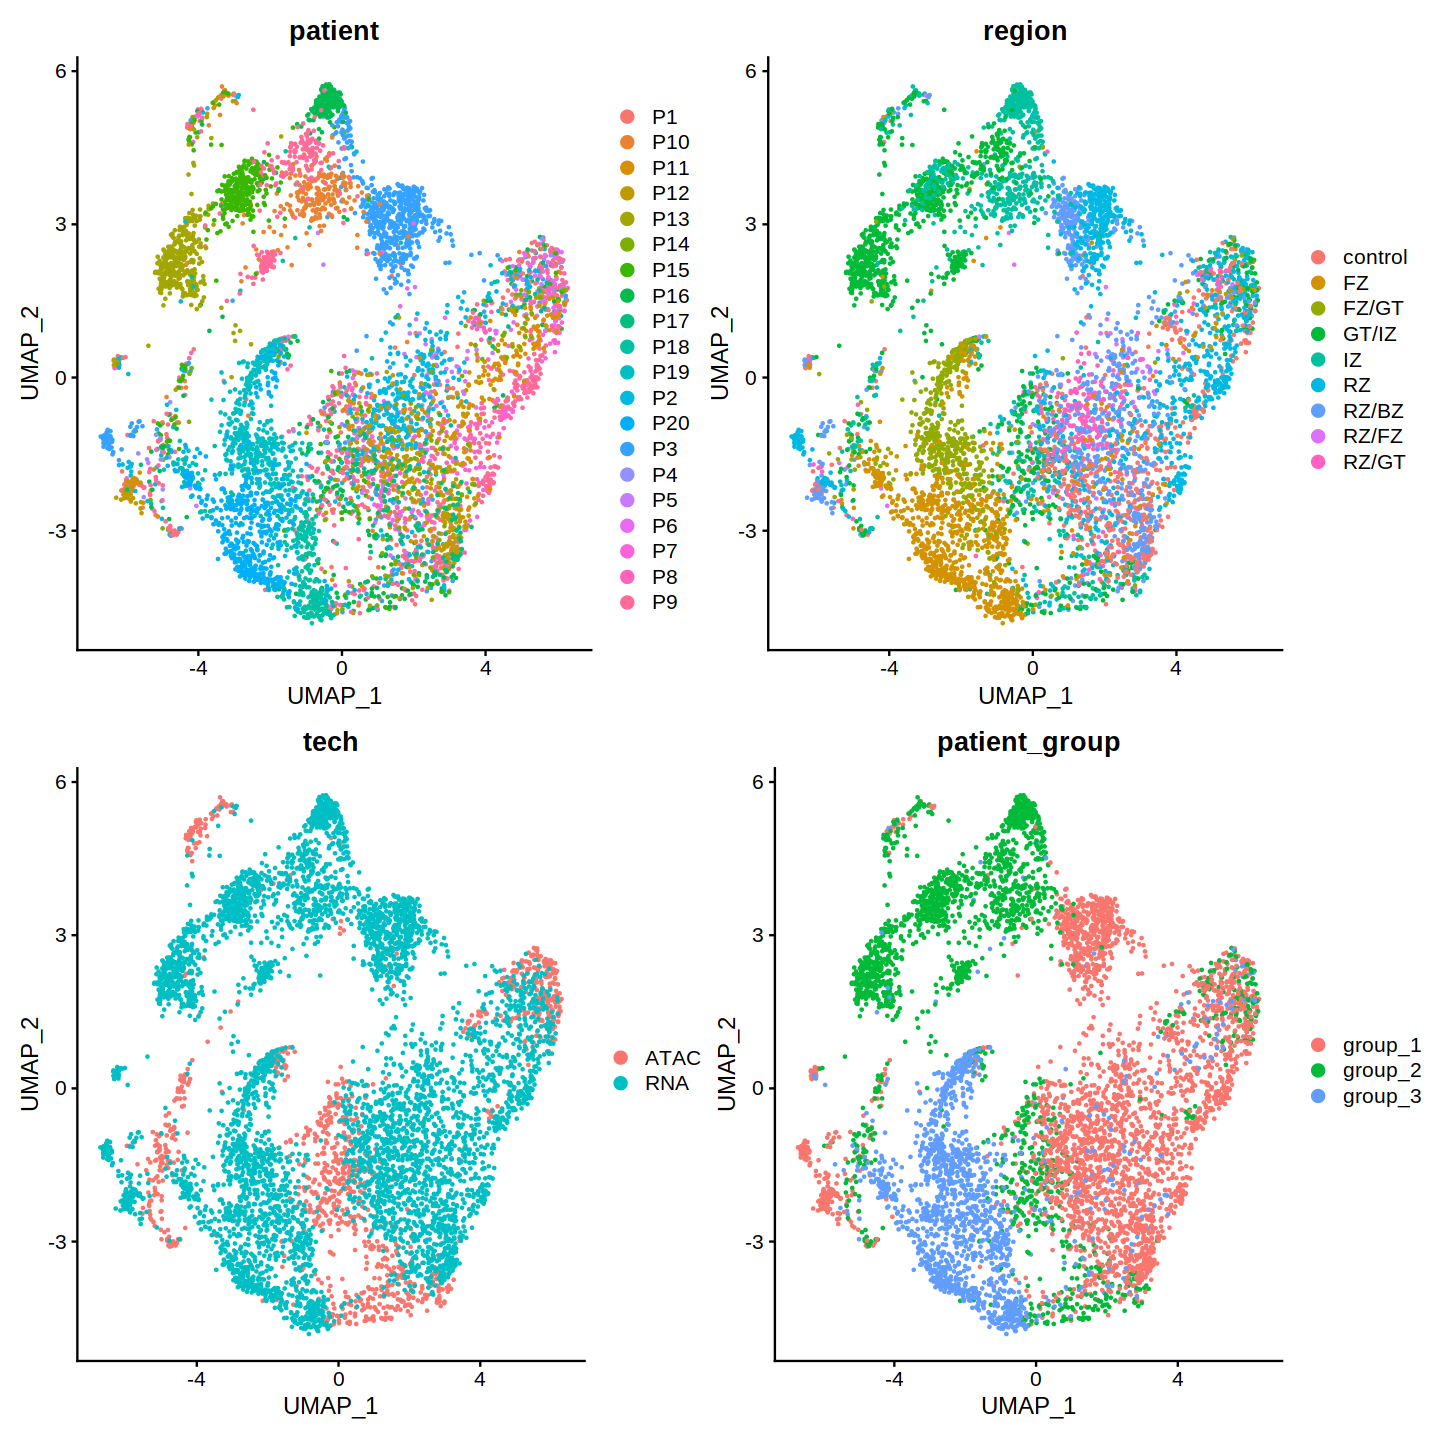

In [33]:
options(repr.plot.height = 12, repr.plot.width = 12)

p1 <- DimPlot(coembed, group.by = "patient")
p2 <- DimPlot(coembed, group.by = "region")
p3 <- DimPlot(coembed, group.by = "tech")
p4 <- DimPlot(coembed, group.by = "patient_group")

(p1 + p2) / (p3 + p4)

Harmony 1/30

Harmony 2/30

Harmony 3/30

Harmony 4/30

Harmony 5/30

Harmony 6/30

Harmony 7/30

Harmony 8/30

Harmony 9/30

Harmony 10/30

Harmony 11/30

Harmony 12/30

Harmony 13/30

Harmony 14/30

Harmony converged after 14 iterations



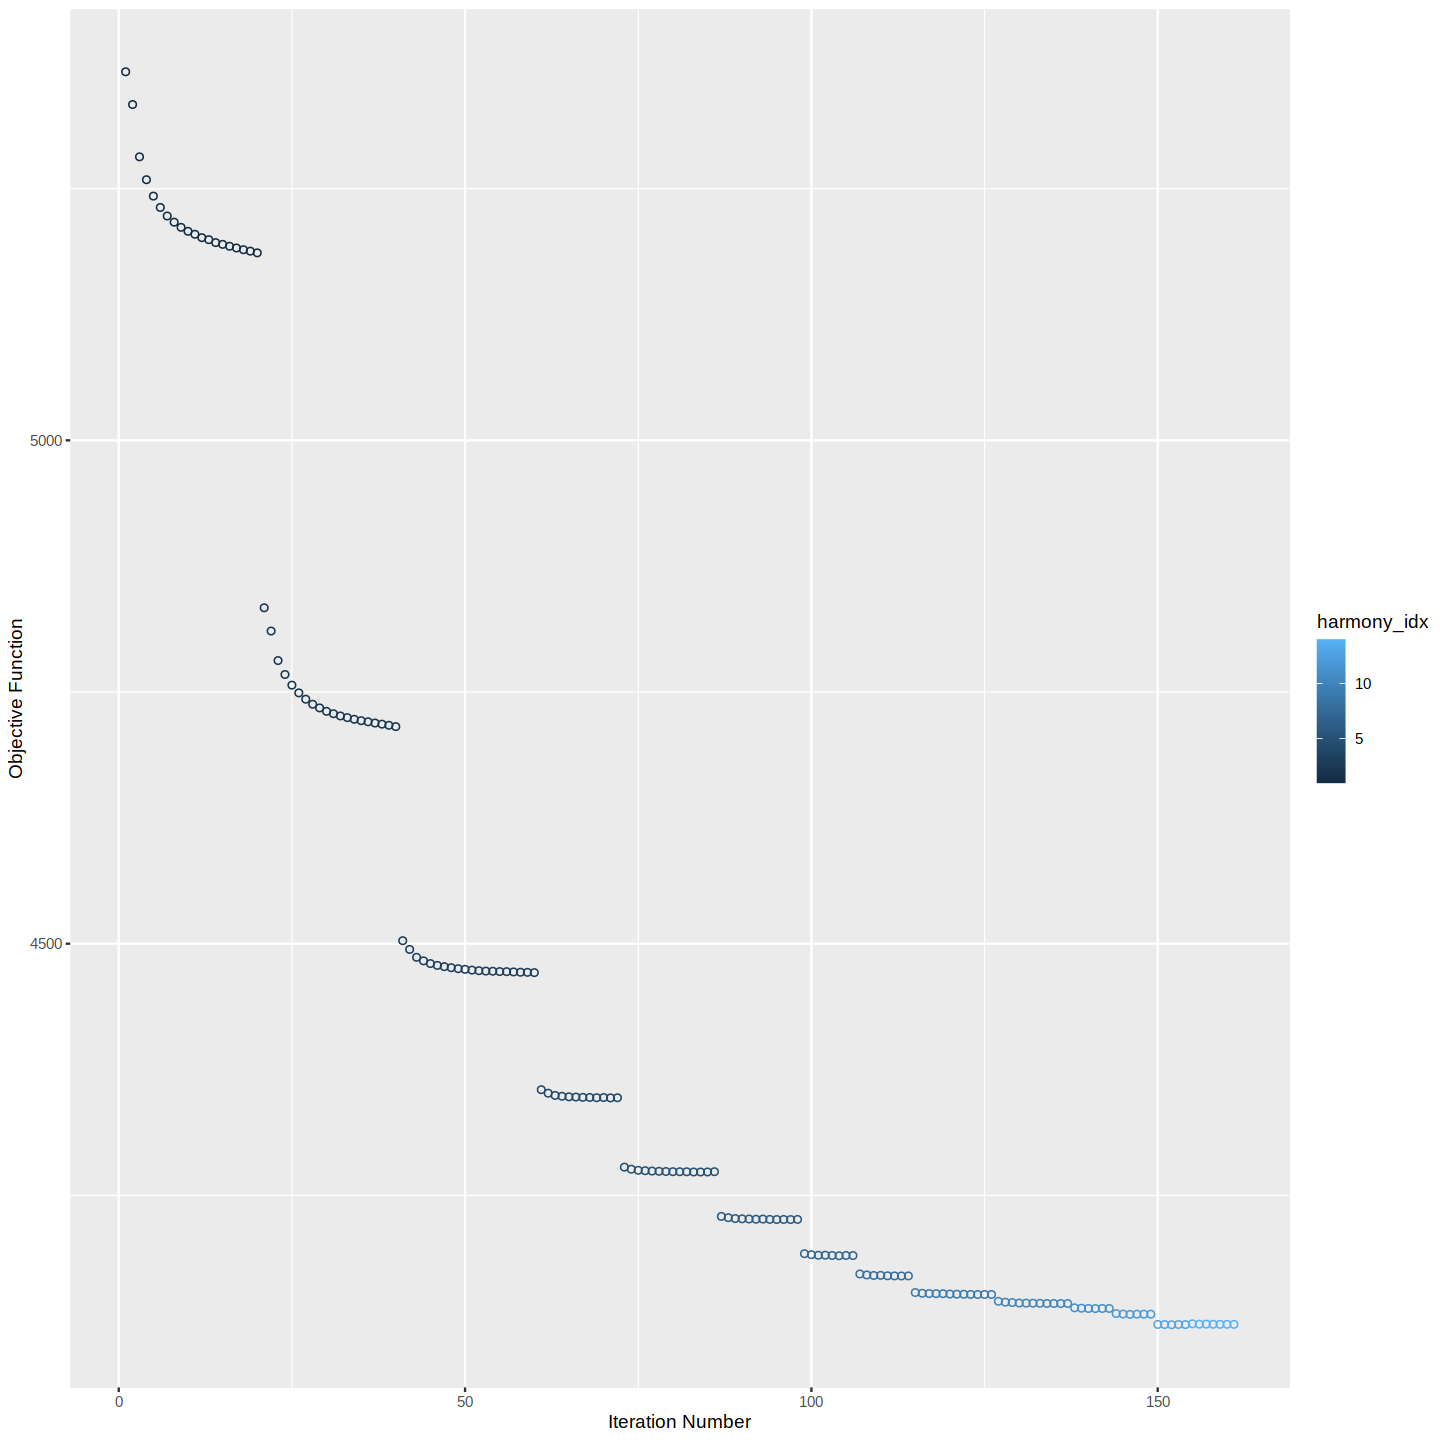

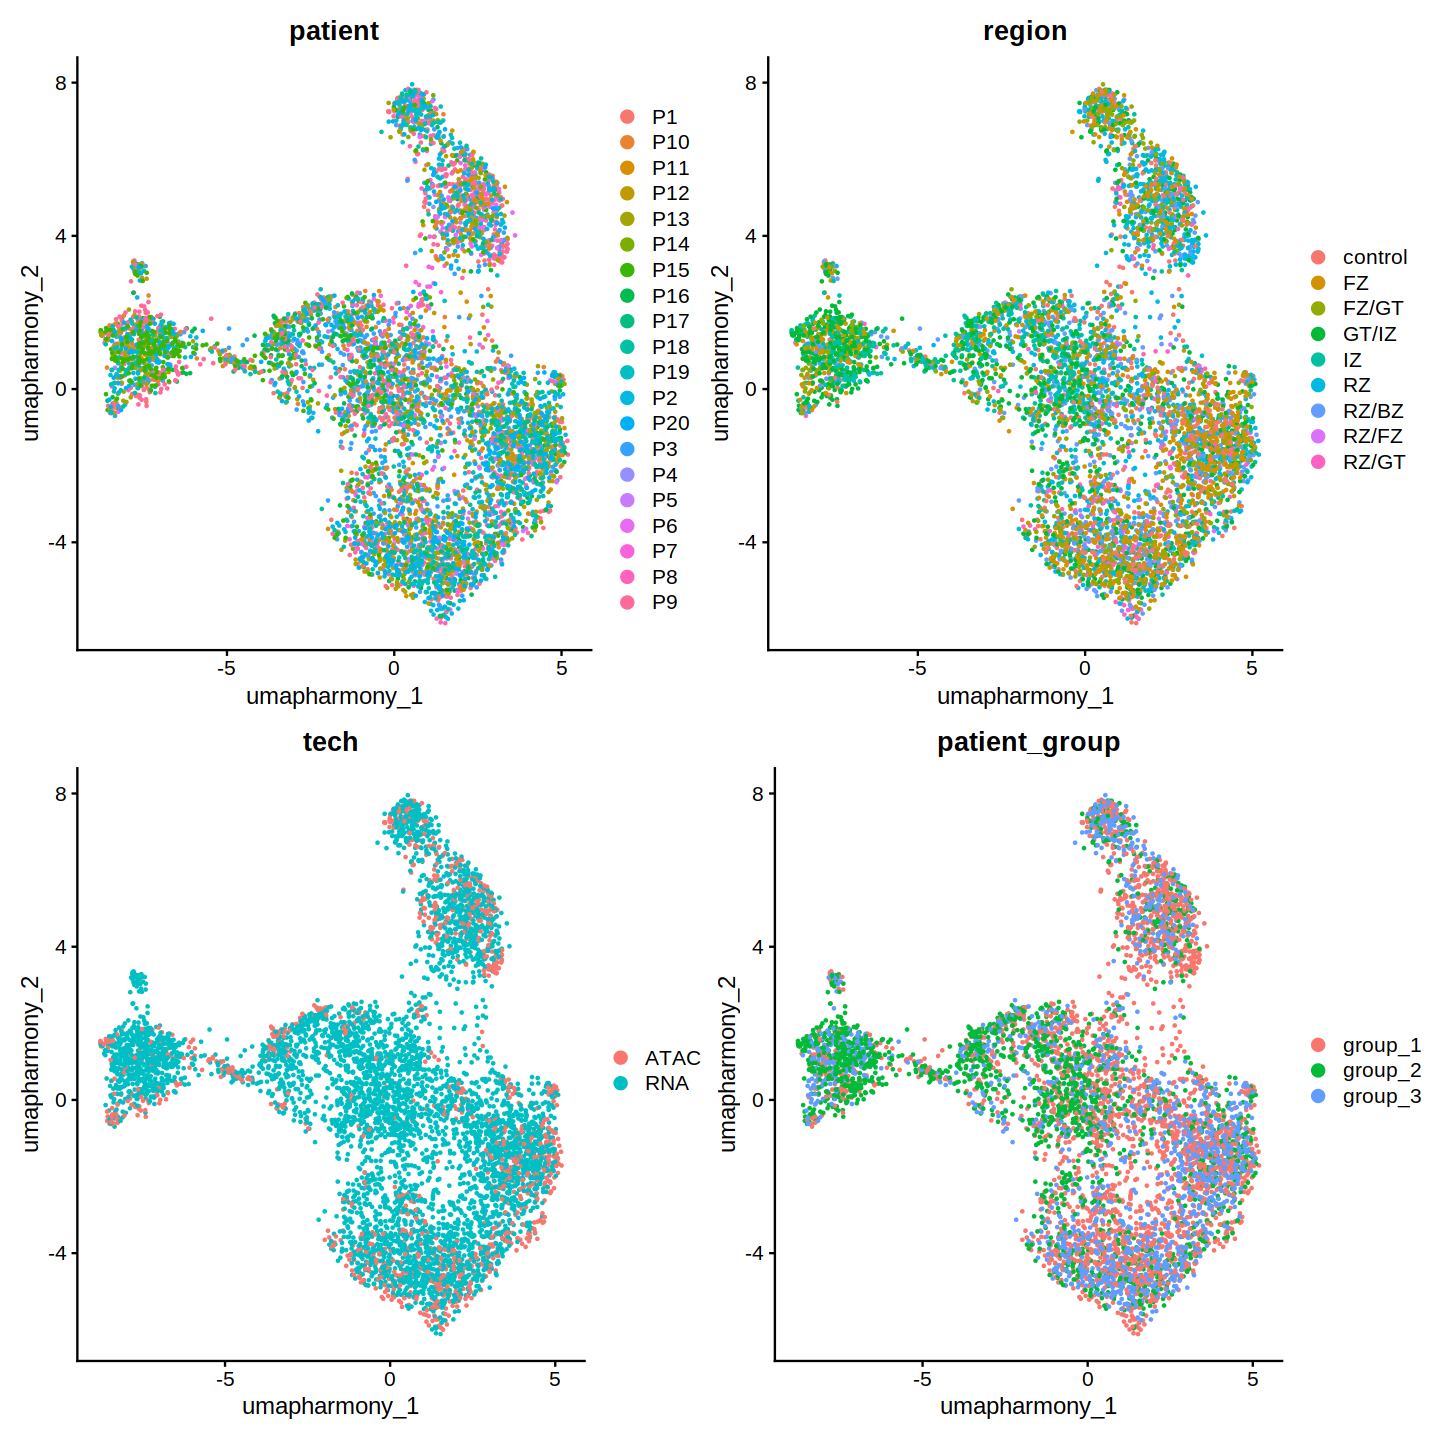

In [34]:
coembed <- RunHarmony(coembed, 
                      group.by.vars = c("patient", "region", "tech"),
                     reduction = "pca", 
                      max.iter.harmony = 30, 
                      dims.use = 1:30,
                     project.dim = FALSE,
                     plot_convergence = TRUE)

coembed <- RunUMAP(coembed, 
               dims = 1:30, 
               reduction = 'harmony',
               reduction.name = "umap_harmony",
               reduction.ke = 'umapharmony_',
              verbose = FALSE,
                   min.dist = 0.4)

options(repr.plot.height = 12, repr.plot.width = 12)

p1 <- DimPlot(coembed, group.by = "patient", reduction = "umap_harmony")
p2 <- DimPlot(coembed, group.by = "region", reduction = "umap_harmony")
p3 <- DimPlot(coembed, group.by = "tech", reduction = "umap_harmony", shuffle = TRUE)
p4 <- DimPlot(coembed, group.by = "patient_group", reduction = "umap_harmony")

(p1 + p2) / (p3 + p4)

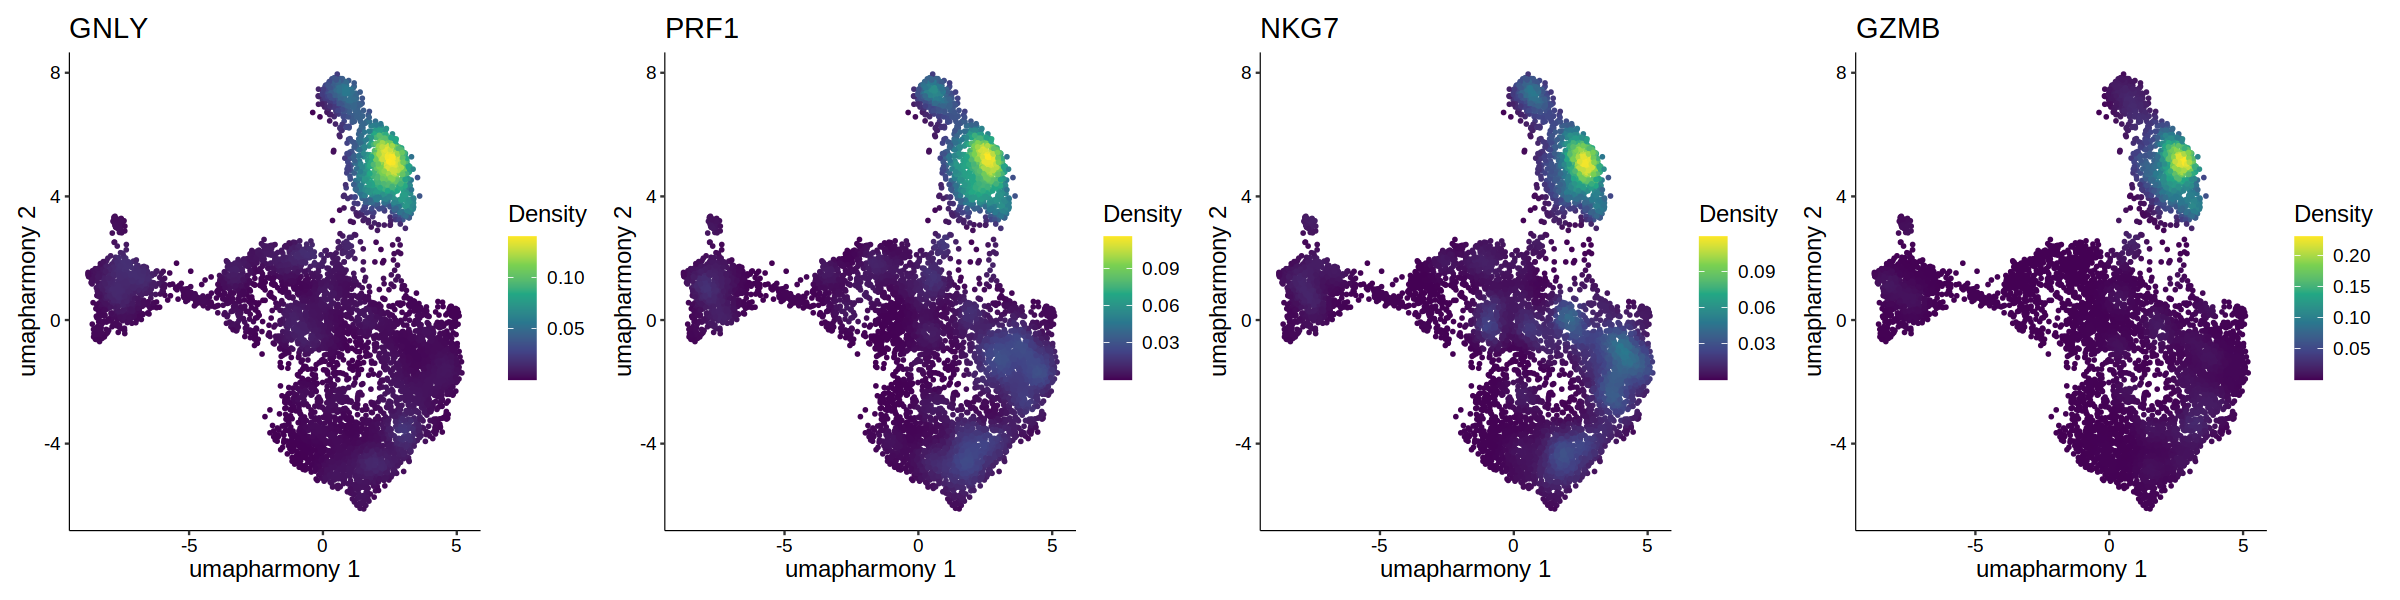

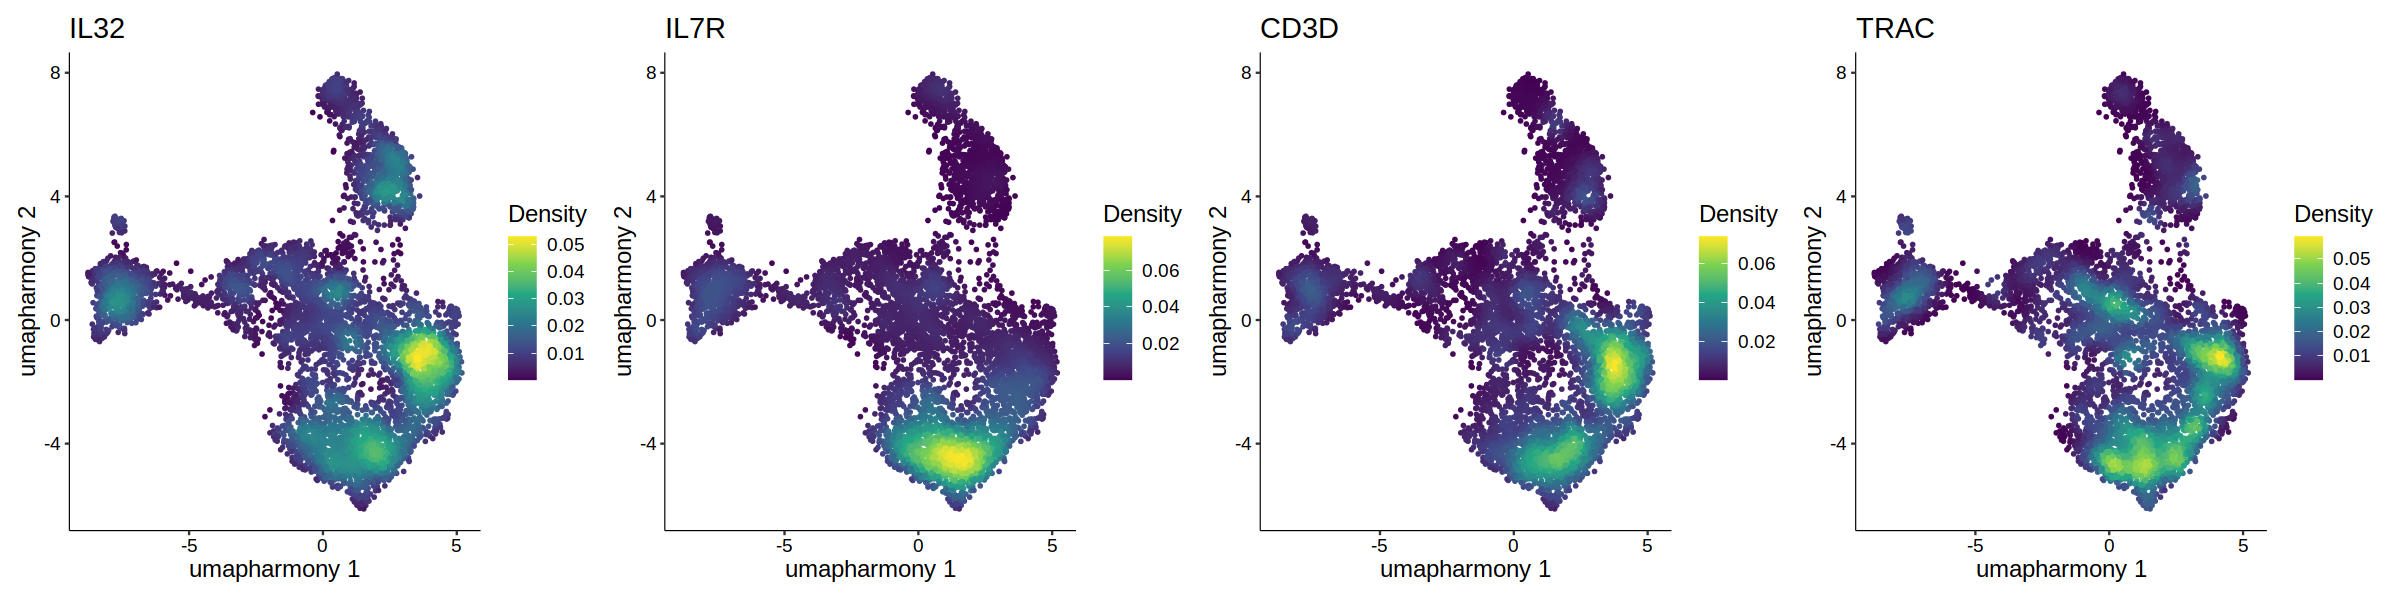

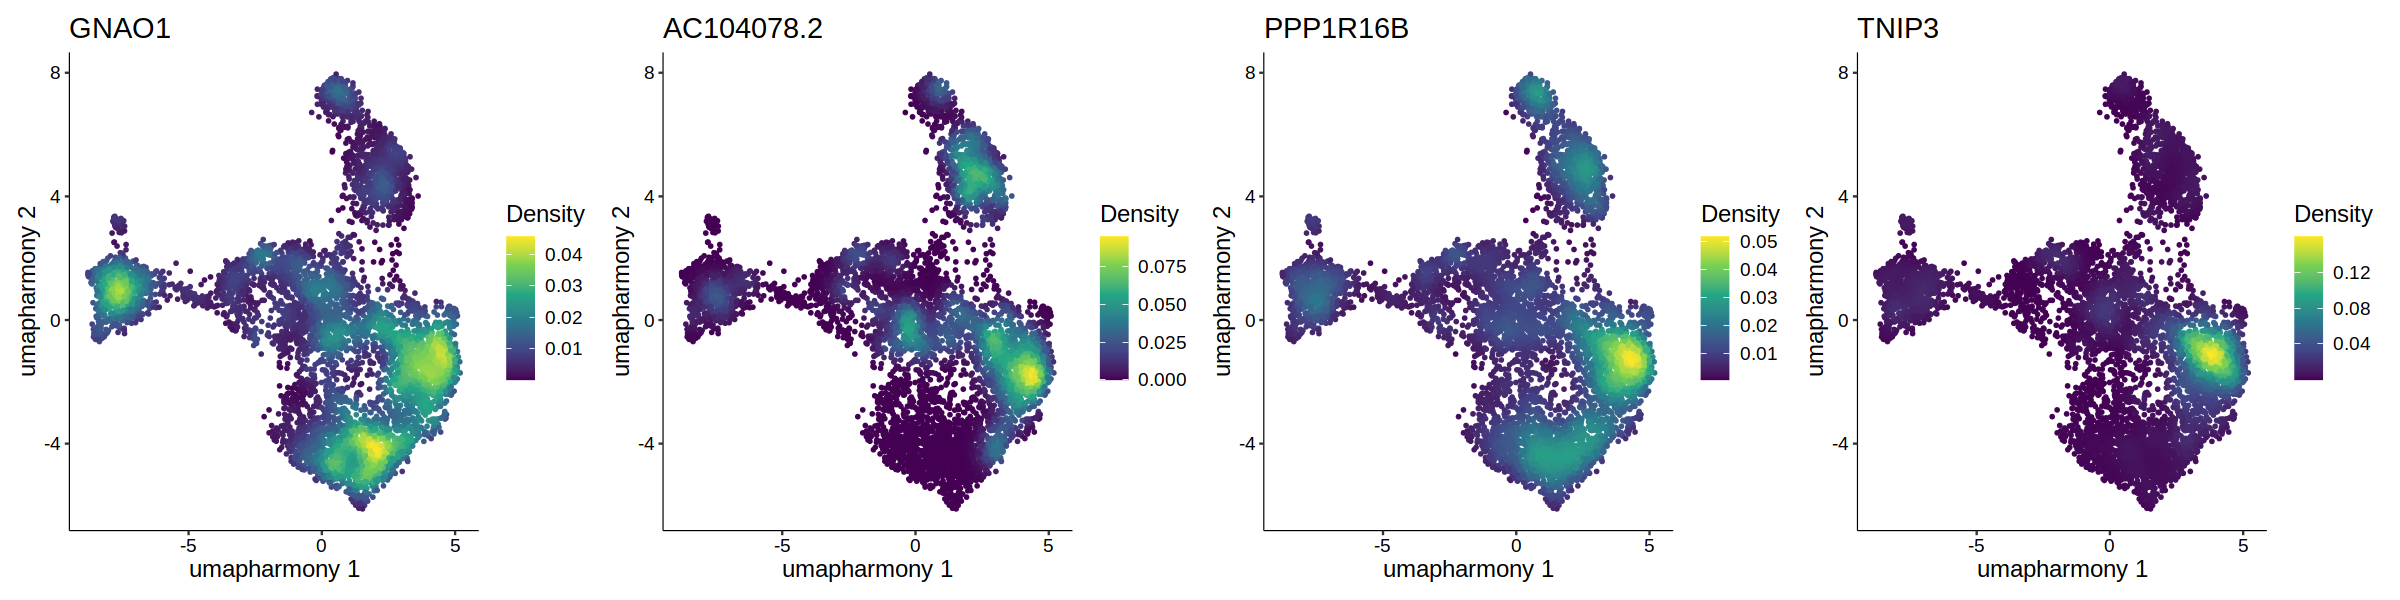

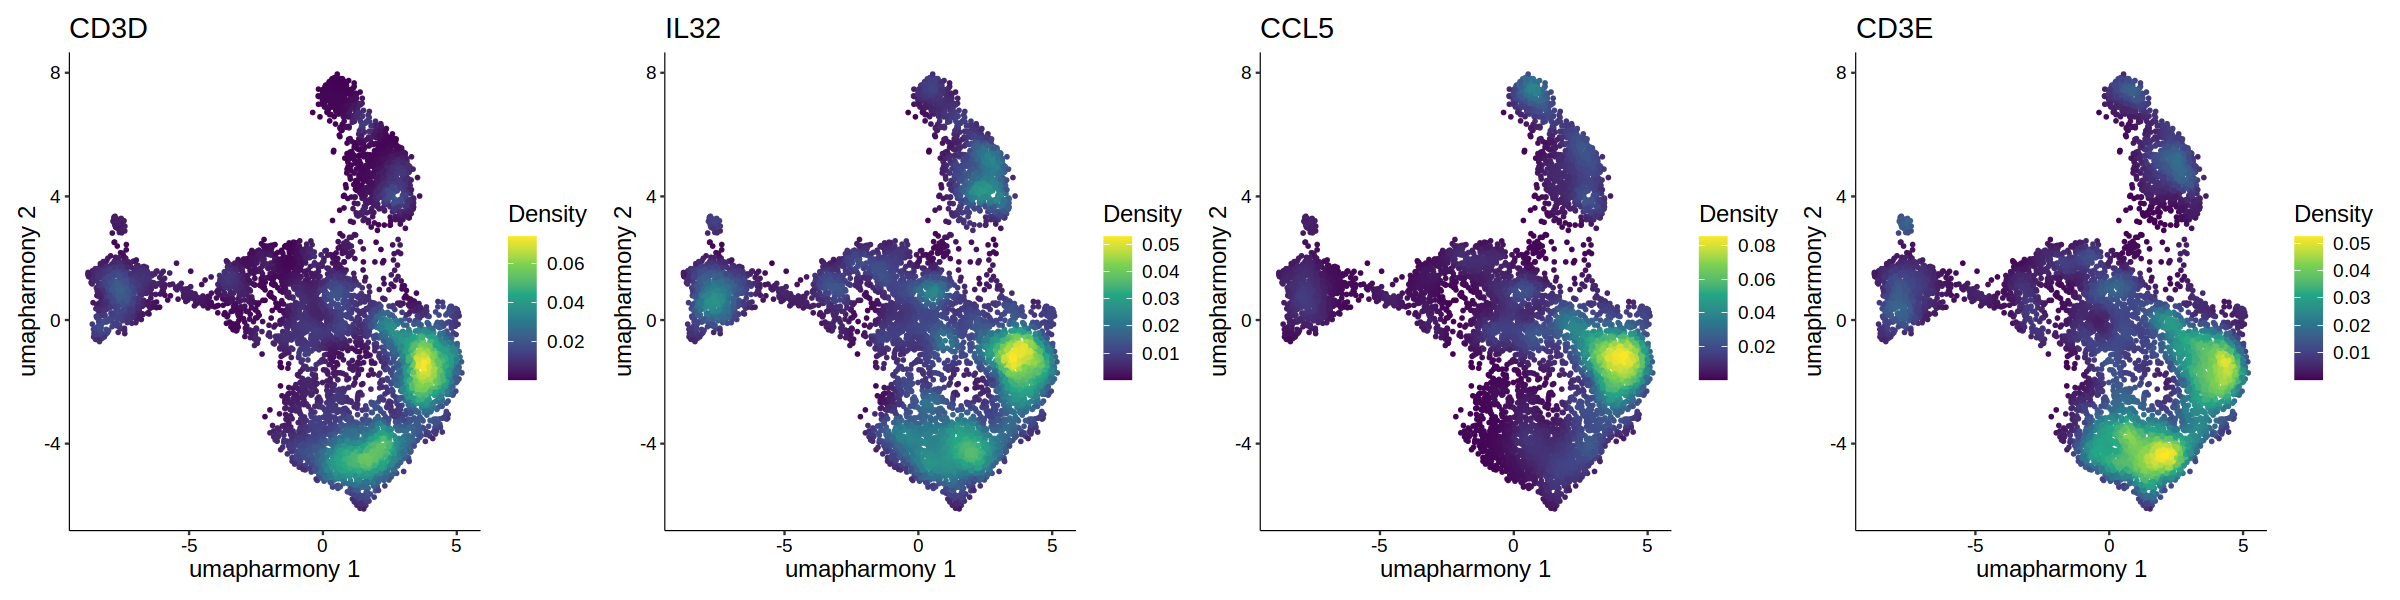

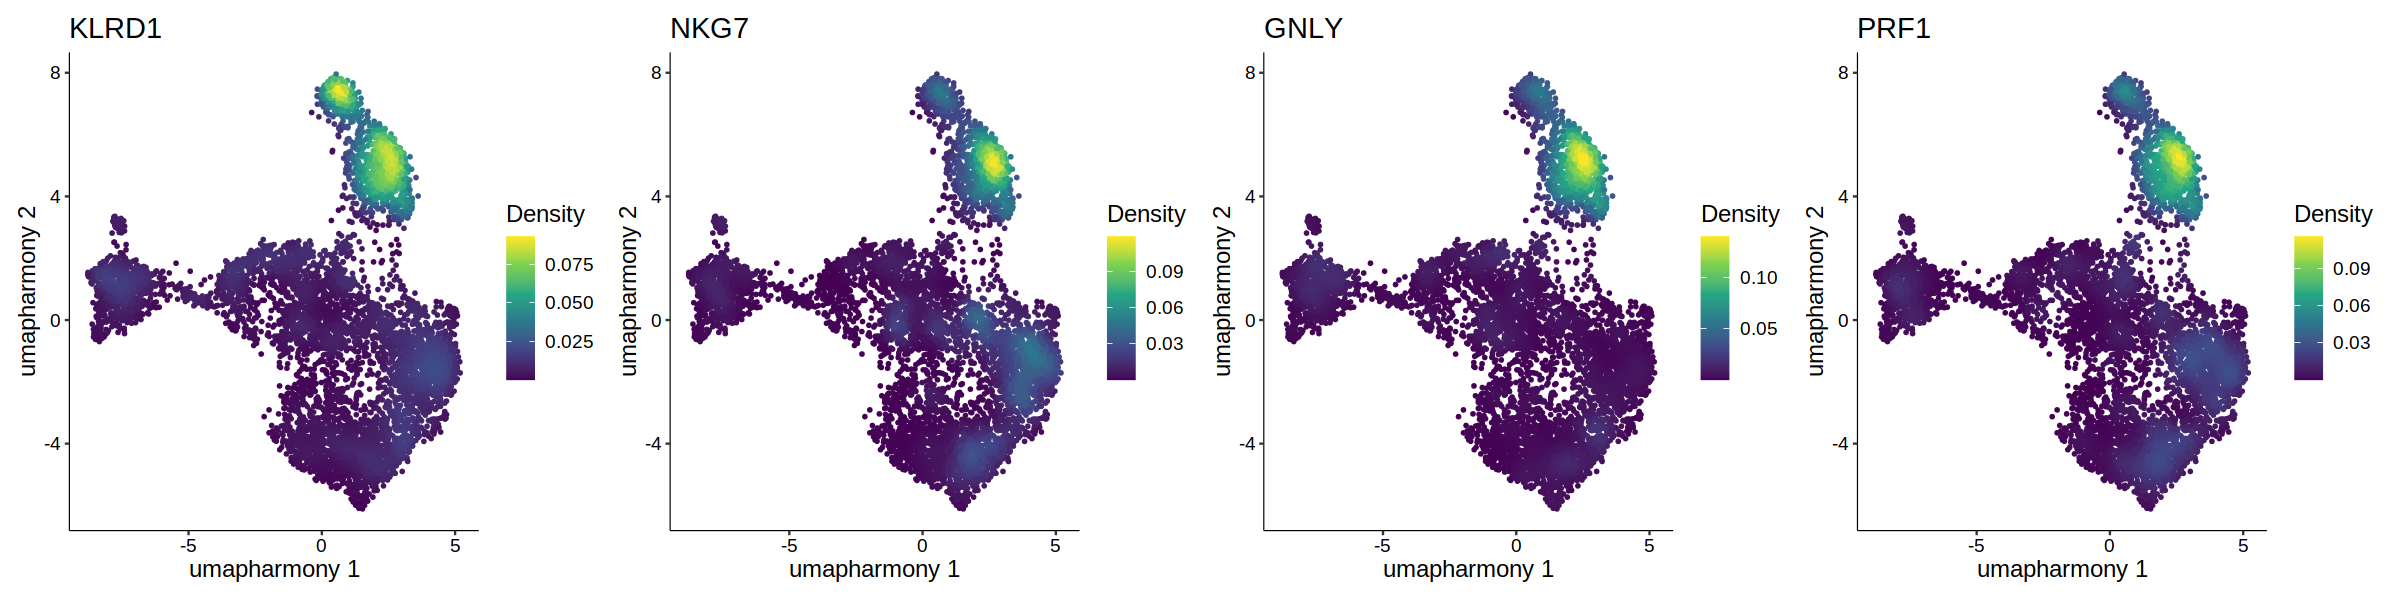

In [35]:
options(repr.plot.height = 5, repr.plot.width = 20)

ps1 <- plot_density(coembed, features=c("GNLY", "PRF1", "NKG7", "GZMB"), reduction="umap_harmony", combine = FALSE)
ps2 <- plot_density(coembed, features=c("IL32", "IL7R", "CD3D", "TRAC"), reduction="umap_harmony", combine = FALSE)
ps3 <- plot_density(coembed, features=c("GNAO1", "AC104078.2", "PPP1R16B", "TNIP3"), reduction="umap_harmony", combine = FALSE)
ps4 <- plot_density(coembed, features=c("CD3D", "IL32", "CCL5", "CD3E"), reduction="umap_harmony", combine = FALSE)
ps5 <- plot_density(coembed, features=c("KLRD1", "NKG7", "GNLY", "PRF1"), reduction="umap_harmony", combine = FALSE)

patchwork::wrap_plots(ps1, nrow = 1)
patchwork::wrap_plots(ps2, nrow = 1)
patchwork::wrap_plots(ps3, nrow = 1)
patchwork::wrap_plots(ps4, nrow = 1)
patchwork::wrap_plots(ps5, nrow = 1)

[[1]]


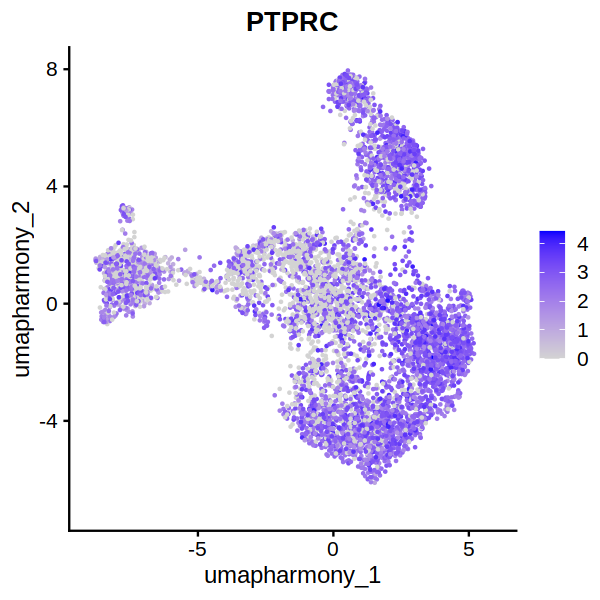

In [45]:
options(repr.plot.height = 5, repr.plot.width = 5)

FeaturePlot(coembed, features=c("PTPRC"), reduction="umap_harmony", combine = FALSE)

In [40]:
obj.rna <- subset(coembed, tech == "RNA")

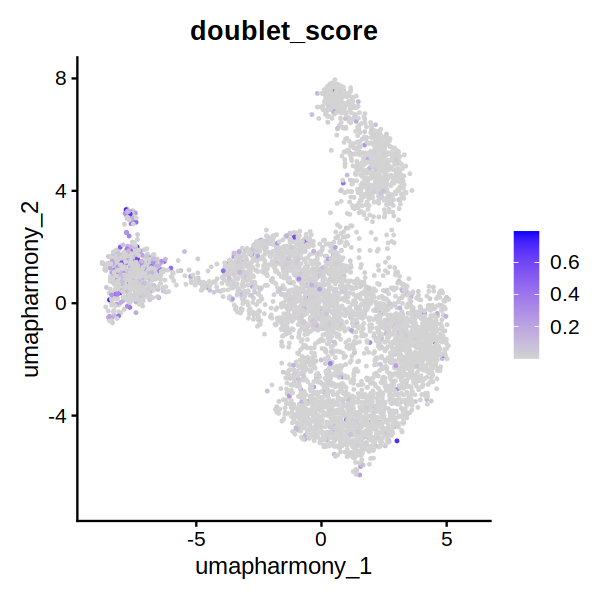

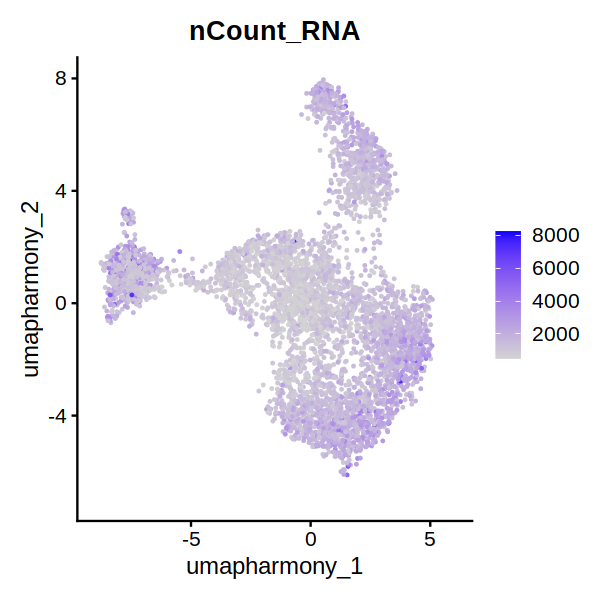

In [42]:
FeaturePlot(obj.rna, "doublet_score", reduction="umap_harmony")
FeaturePlot(obj.rna, "nCount_RNA", reduction="umap_harmony")

In [26]:
resolutions <- seq(0.2, 1, 0.1)

coembed <- FindNeighbors(coembed, reduction = "harmony", dims = 1:30)
coembed <- FindClusters(coembed, resolution = resolutions, verbose = FALSE)

Computing nearest neighbor graph

Computing SNN



Warning message:
“The `add` argument of `group_by()` is deprecated as of dplyr 1.0.0.
Please use the `.add` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


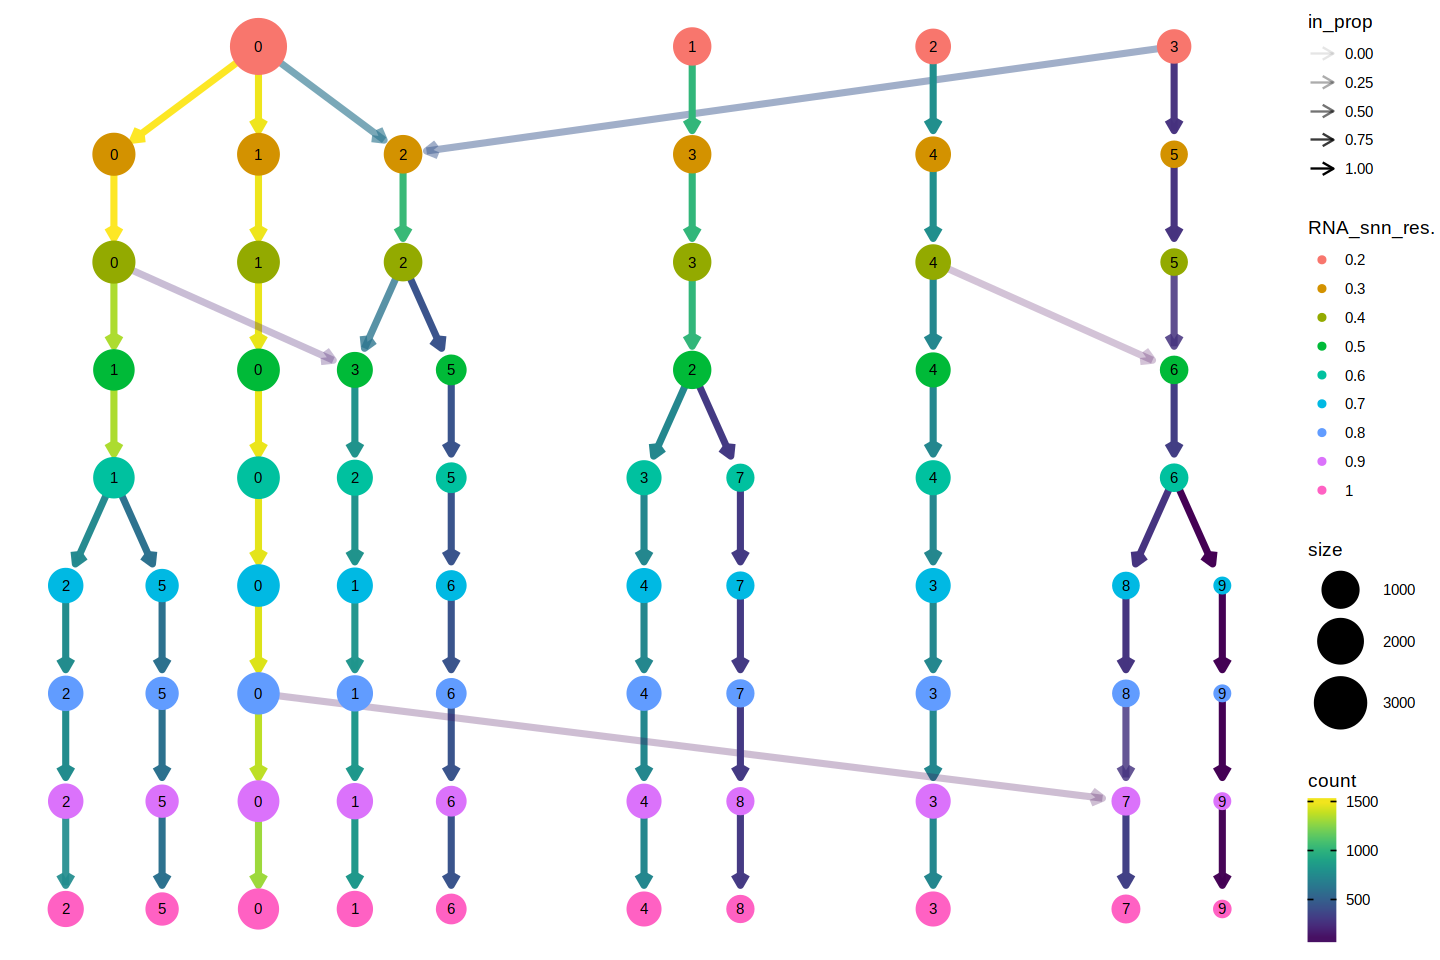

In [27]:
library(clustree)

options(repr.plot.height = 8, repr.plot.width = 12)

clustree(coembed, prefix = "RNA_snn_res.")

In [ ]:
options(repr.plot.height = 15, repr.plot.width = 18)

plotlist <- lapply(resolutions, function(x){
    cols <- ArchR::paletteDiscrete(coembed@meta.data[, glue::glue("RNA_snn_res.{x}")])
    
    p <- DimPlot(coembed, group.by = glue::glue("RNA_snn_res.{x}"), label = TRUE,
             reduction = "umap_harmony", shuffle = TRUE) +
    scale_color_manual(values = cols) +
    xlab("UMAP1") + ylab("UMAP2")
    
    p
})

p <- patchwork::wrap_plots(plotlist, ncol = 3)

p

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 5)


for(x in resolutions){
    cols <- ArchR::paletteDiscrete(coembed@meta.data[, glue::glue("RNA_snn_res.{x}")])
    p <- DimPlot(coembed, group.by = glue::glue("RNA_snn_res.{x}"), split.by = "tech", reduction = "umap_harmony", cols=cols)
    
    print(p)
}

In [ ]:
options(repr.plot.height = 4, repr.plot.width = 15)

if(!dir.exists("../data/coembed/MarkerGenes")){
    dir.create("../data/coembed/MarkerGenes")
}

for(res in resolutions){
    Idents(coembed) <- glue::glue("RNA_snn_res.{res}")
    all.markers <- FindAllMarkers(coembed, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
    
    df <- all.markers %>%
    group_by(cluster) %>%
    slice_max(n = 10, order_by = avg_log2FC)
    
    p <- DotPlot(coembed, features = unique(df$gene)) + RotatedAxis() + ggtitle(glue::glue("RNA_snn_res.{res}"))
    
    print(p)
    
    markerList <- split(all.markers, all.markers$cluster)
    
    for(i in 1:length(markerList)){
        markerList[[i]] <- markerList[[i]][order(-markerList[[i]]$avg_log2FC), ]
    }
    
    WriteXLS::WriteXLS(markerList,
                   ExcelFileName = glue::glue("../data/coembed/MarkerGenes/res.{res}.xlsx"),
                   SheetNames = names(markerList))

    saveRDS(all.markers, glue::glue("../data/coembed/MarkerGenes/res.{res}.rds"))
}

In [ ]:
saveRDS(coembed, file = "../data/coembed/coembed.Rds")

In [ ]:
sessionInfo()